<a href="https://colab.research.google.com/github/juansebastiancalderongarcia/Motor-control-for-speed-transition/blob/main/Sebastian_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
from torch.optim import Adam
from torch import nn
import numpy as np
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

For all the speeds the dynamics is run over a total time of 2500. That is the reason why all the fast versions of the movement are set to zero in the remaining time

In [2]:
drive.mount('/mydrive')

Mounted at /mydrive


In [3]:
cd /mydrive/MyDrive/'Motor control'

/mydrive/MyDrive/Motor control


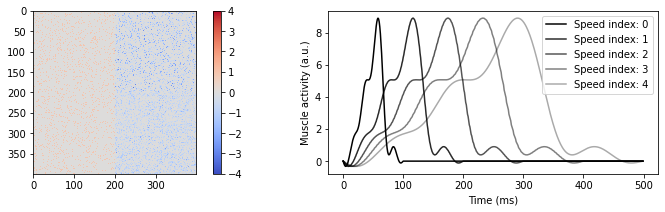

In [4]:
#Load the muscle activity
muscle_activity = np.load('./muscle_activity.npy')
#Load the Wsoc and the initial condition for the dynamics
with open('initial_dynamics.npy', 'rb') as f: 
    Wsoc = np.load(f)
    x0 = np.load(f)
#Plot the muscle activity
fig, (ax1,ax2) = plt.subplots(figsize = (13,3), ncols = 2)
pos = ax1.imshow(Wsoc, cmap = 'coolwarm', vmin=-4, vmax=4, interpolation = 'none')
fig.colorbar(pos, ax=ax1)
for i in range(muscle_activity.shape[1]):
  ax2.plot(muscle_activity[:,i], color = 'k', alpha = 1 - i/6, label = "Speed index: "+str(i))
ax2.set_xlabel('Time (ms)') 
ax2.legend()
ax2.set_ylabel('Muscle activity (a.u.)') 
fig.show()

# RNN

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$x_{t+1} = x_{t} + \frac{1}{\tau}(-x_{t} + Wf(x_t,g))$$


$$z_t = m^T f(x_t,g) + b$$
<!-- $$ f(x,g) = \  $$ -->

In [7]:
muscle_activity_tensor = torch.tensor(muscle_activity, dtype=torch.float32).cuda()
print(muscle_activity_tensor.shape)

torch.Size([500, 5])


In [83]:
class RNNDynamics(nn.Module):
    def __init__(self, 
                 input_dim, # number of neurons * number of conditions
                 output_dim, # z dimension?
                 r_0 = 20,
                 r_max = 100,
                 tau = 200): 

        super(RNNDynamics, self).__init__()

        # create connectivity matrix with absolute random values
        self.W = torch.tensor(Wsoc, dtype=torch.float32).cuda()

        # creating g parameters
        # g = gain parameters for the slow version
        # g0 = gain parameters for the fast version constrained to be one

        self.g = nn.Parameter(torch.ones(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=True)
        self.g0 = nn.Parameter(torch.ones(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=False)
        
        self.h = 2500/500
        self.tau = tau
        self.r_0 = r_0
        self.r_max = r_max
        self.W_out = nn.Linear(400//2, 
                               1, 
                               bias=True) # `m` and `b` weights

    def f(self, x, g):

        mask = x < 0
        R = torch.empty_like(x).cuda() #[1,N]
        R[mask] = self.r_0
        R[~mask] = self.r_max-self.r_0

        return R * torch.tanh(x*g*(1./R)) #[1,N]

    def f_dynamics(self, x, g):
        F = torch.matmul(self.W, self.f(x,g).T).T
        return (1/self.tau)*(-x + F)     

    def forward(self,x_slow, x_fast):

        F_slow = torch.matmul(self.W, self.f(x_slow,self.g).T).T
        F_fast = torch.matmul(self.W, self.f(x_fast,self.g0).T).T 

        # choosing excitatory neurons for the slow version
        excitatory_mask_slow = self.W.sum(0) > 0
        F_exc_slow = F_slow[excitatory_mask_slow.unsqueeze(0)].unsqueeze(0)

        # choosing excitatory neurons for the slow version
        excitatory_mask_fast = self.W.sum(0) > 0
        F_exc_fast = F_fast[excitatory_mask_fast.unsqueeze(0)].unsqueeze(0)

        #RK4 parameters
        k1_slow = self.f_dynamics(x_slow, self.g)
        k2_slow = self.f_dynamics(x_slow + (self.h/2)*k1_slow, self.g)
        k3_slow = self.f_dynamics(x_slow + (self.h/2)*k2_slow, self.g)
        k4_slow = self.f_dynamics(x_slow + self.h*k3_slow, self.g)

        k1_fast = self.f_dynamics(x_fast, self.g0)
        k2_fast = self.f_dynamics(x_fast + (self.h/2)*k1_fast, self.g0)
        k3_fast = self.f_dynamics(x_fast + (self.h/2)*k2_fast, self.g0)
        k4_fast = self.f_dynamics(x_fast + self.h*k3_fast, self.g0)

        # W_out already includes m^T and b
        z_current_fast = self.W_out(F_exc_fast)
        x_new_fast = x_fast + (self.h/6)*(k1_fast + 2*k2_fast + 2*k3_fast + k4_fast)
        #x_new_fast = x_fast + (1/self.tau_fast)*(-x_fast + F_fast)

        z_current_slow = self.W_out(F_exc_slow)
        x_new_slow = x_slow + (self.h/6)*(k1_slow + 2*k2_slow + 2*k3_slow + k4_slow)
        #x_new_slow = x_slow + (1/self.tau_slow)*(-x_slow + F_slow)

        return z_current_slow, z_current_fast, x_new_slow, x_new_fast

In [1]:
N = 400
y_index = -1
n_epochs = 200
T,output_dim = muscle_activity_tensor.shape #[T,1]

rnn_dynamic = RNNDynamics(input_dim=2*N, # number of neurons * 2 conditions
                          output_dim=1*2, # z dimension * 2 conditions
                          r_0=20,
                          r_max=100).cuda()

#opt = Adam(rnn_dynamic.parameters(), lr = 1e-3, weight_decay = 1 )

opt = torch.optim.Adam(
[{'params': rnn_dynamic.W_out.parameters(), 'lr':1e-3, 'weight_decay':1}] +\
[{'params': rnn_dynamic.g, 'lr': 1e-3, 'weight_decay':0}]
)

x_slow_seqs = []
z_slow_seqs = []

x_fast_seqs = []
z_fast_seqs = []

losses = []

with torch.autograd.detect_anomaly():
  for ep in tqdm(range(n_epochs)):

    x_slow_seq = []
    z_slow_seq = []

    x_fast_seq = []
    z_fast_seq = []


    # Initial activity
    x_slow = torch.abs(torch.tensor(x0.T, dtype=torch.float32)).cuda()
    x_fast = torch.abs(torch.tensor(x0.T, dtype=torch.float32)).cuda()

    for t in range(T):
        z_current_slow, z_current_fast, x_slow, x_fast = rnn_dynamic(x_slow, x_fast)

        x_slow_seq.append(x_slow)
        z_slow_seq.append(z_current_slow)

        x_fast_seq.append(x_fast)
        z_fast_seq.append(z_current_fast)

    x_slow_seq = torch.cat(x_slow_seq, dim=0)
    x_fast_seq = torch.cat(x_fast_seq, dim=0)

    z_slow_seq = torch.cat(z_slow_seq, dim=0)
    z_fast_seq = torch.cat(z_fast_seq, dim=0)

    loss = torch.pow(torch.norm(z_slow_seq.squeeze() - muscle_activity_tensor[:,-1]), 2) + torch.pow(torch.norm(z_fast_seq.squeeze() - muscle_activity_tensor[:,0]), 2)
    
    opt.zero_grad()
    loss.backward() 
    opt.step()
    losses.append(loss.item())

    x_slow_seqs.append(x_slow_seq.detach().cpu().numpy())
    x_fast_seqs.append(x_fast_seq.detach().cpu().numpy())

    z_slow_seqs.append(z_slow_seq.detach().cpu().numpy())
    z_fast_seqs.append(z_fast_seq.detach().cpu().numpy())

x_slow_seqs = np.array(x_slow_seqs)
z_slow_seqs = np.array(z_slow_seqs)

x_fast_seqs = np.array(x_fast_seqs)
z_fast_seqs = np.array(z_fast_seqs)


NameError: ignored

(10, 500, 400)


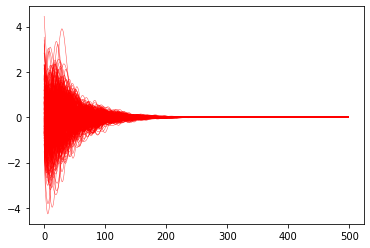

In [85]:
print(x_fast_seqs.shape)
plt.plot(x_fast_seqs[-1,:,:], color = 'red', alpha = 0.7, linewidth = 0.5)
plt.show()

(10, 500, 400)


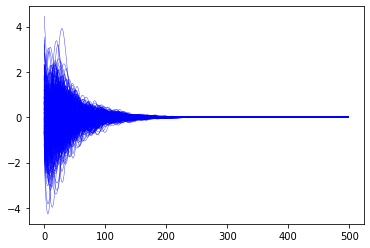

In [86]:
print(x_fast_seqs.shape)
plt.plot(x_slow_seqs[-1,:,:], color = 'blue', alpha = 0.7, linewidth = 0.5)
plt.show()

9720.4931640625


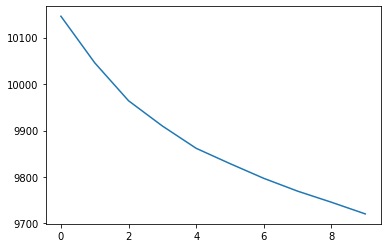

In [87]:
plt.plot(losses)
print(losses[-1])

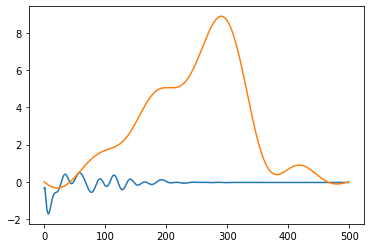

In [88]:
plt.plot(z_slow_seqs[-1])
plt.plot(muscle_activity_tensor[:,-1].detach().cpu().numpy())

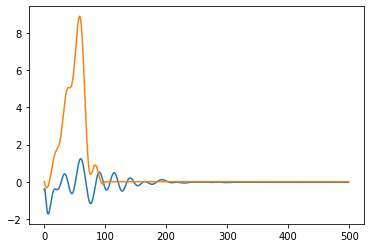

In [89]:
plt.plot(z_fast_seqs[-1])
plt.plot(muscle_activity_tensor[:,0].detach().cpu().numpy())
